In [122]:
#Imports
import numpy as np
import matplotlib.pyplot as plt

# ASE
from ase.db import connect
from ase.io import write

# Plot details
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Task 1 - Run the genetic algorithm

The genetic algorithm was succesfully run for Na clusters with 6, 7 and 8 atoms respectively.

# Task 2 - What does the scripts do?

## initialization.py

Initializes the system for a given number N of Na atoms. The script is composed of a main function which initializes the system, using several helper functions. First, arguments given to the script are parsed, and a database file (gadb.db) and a Lennard-Jones-potential-based calculator (calc) are created. Then, the cluster is created with N Na-atoms. The function 'closest_distances_generator' is used to find the smallest possible initial bond lengths, which are then passed to the class 'StartGenerator' which takes care of creating starting candidates for our Na cluster. After the slab parameters, which define the volume available to our system, of our StartGenerator are set we use StartGenerator to generate population_size number of starting candidates. These are generated by first adding an atom at (0,0,0), after which the rest of the N atoms are added iteratively by randomly trying different angles and positions next to the already placed atoms. The atoms are placed at the bond-distance calculated using the 'closest_distances_generator' from ASE. Each obtained starting cluster is then relaxed using the Lennard-Jones potential. Finally, all of the (unrelaxed?) candidates are saved to the database file. 

## ga.py

Takes the output from initialization.py. First, all of the unrelaxed candidates fron gadb.db are loaded, and a GPAW-based calculator is defined (calc). Then, they are each relaxed for 100 steps using calc and saved back to gadb.db. These relaxed candidates are also added to our population-object. Then, the genetic algorithm (GA) starts. For each of the ncandidates_to_test, two random candidates out of the population are selected and "paired" to create a third candidate. "Pairing" in this sense means that atoms from both parents are "sliced-out" and combined to form a new candidate. With a certain probablilty mutation_probability a random mutation is also added to the new candidate by performing some operation, such as mirroring, rattle or permutation of the atoms. The new candidate is the relaxed, and added to the population after which the process is repeated. 

Finally, all relaxed candidates of the population are saved to the file 'all_candidates.traj'.

# Task 3 - Expected outcome

Create three clusters of 6, 7 and 8 Na-atoms respectively, configured according to my expectation. I expect the atoms to be placed as close to each other as possible and in a symmetric manner, in order to minimize the energy of the system. Thus I guess that the 6 Na-atom structure will be in a 3D pyramid-like shape with two points. For the 7 and 8 Na-atom clusters I have no real intuition, and use the random-placement-get-out-of-jail card and place the atoms randomly.

In [ ]:
# Built-in packages
import time

# Third-party packages
import numpy as np

from ase import Atoms
from ase.ga.utilities import closest_distances_generator
from ase.visualize import view
from ase.optimize import GPMin

from gpaw import GPAW, FermiDirac


np.random.seed(1)
d = 20  # cell size
db_file = 'expect.db'  # Filename for each of the databases

def create_relaxed_Na_cluster(N, view=False):
    print(f'************ Na{N} ************')
    start = time.time()
    dirpath=f'./Na{N}/'  # Path where everything will be saved
    #**** Initialize system ****#
    if N==6:
        clust = Atoms('Na'*6, positions=[(1,1,0),(1,-1,0),(-1,-1,0),(-1,1,0),(0,0,1),(0,0,-1)], cell=(d, d, d))
    else:
        clust = Atoms('Na'*N, positions=[np.random.randn(3) for i in range(N)], cell=(d, d, d))  # random initialization
    clust.center()
    if view:
        view(clust)
    #**** Define the calculator ****#
    calc = GPAW(nbands=10,
                h=0.25,
                txt=f'{dirpath}out.txt',
                occupations=FermiDirac(0.05),
                setups={'Na': '1'},
                mode='lcao',
                basis='dzp')
    #**** Relax the system ****#
    clust.set_calculator(calc)
    dyn = GPMin(clust, trajectory=f'{dirpath}relax_clust.traj', logfile='{dirpath}relax_clust.log')
    print(f'**** Relaxing system of {N} atoms ****')
    dyn.run(fmax=0.02, steps=100)
    #**** Calculate energy and wavefunction ****#
    e = clust.get_potential_energy()  # Note opposite signa from ga.py
    print(f'Na{N} cluster energy: {e} eV', file=f'{dirpath}e_cluster')
    calc.write(f'{dirpath}Na{N}_cluster.gpw', mode='all')
    end = time.time()
    print(f'**** Elapsed time: {end-start} s ****')
    print('*****************************\n')
    #*****************************#

Ns = [6,7,8]
for N in Ns:
    create_relaxed_Na_cluster(N)

The script above yielded the following energies for my guessed structures: 

* $\rm Na_{6,exp}$ $\rightarrow E \approx -4.1521 \rm\, eV$
* $\rm Na_{7,exp}$ $\rightarrow E \approx -5.5934 \rm\, eV$
* $\rm Na_{8,exp}$ $\rightarrow E \approx -7.2645 \rm\, eV$.

The total run-time on Hebbe for this script was around 42 minutes.

# Task 4 - Relaxation

This insufficient since we are only testing a limited number of configurations of our system, making it possible to get stuck in a local energy minima in configuration space.

# Task 5 - Collect the results

In [113]:
def view_results_and_to_xyz(N):
    dirpath_t1 = f'./task1/Na{N}/'
    dirpath_t5 = f'./task5/'
    db = connect(f'{dirpath_t1}gadb.db')
    id_min, E_min = 0, 0
    for row in db.select(relaxed=True):
        # Find lowest energy candidate
        if row.energy < E_min:
            E_min = row.energy
            id_min = row.id
    print(f'Minimum energy for Na{N} cluster: e = {E_min:.4f} eV with id={id_min}')
    a = db.get(f'id={id_min}').toatoms()
    #**** View atoms - save to a png file ****#
    view(a)
    write(filename=f'{dirpath_t5}Na{N}_min.png', images=a)
    #**** Save atoms to XYZ ****#
    write(filename=f'{dirpath_t5}Na{N}_min.xyz', images=a)

Ns = [6,7,8]
for N in Ns:
    view_results_and_to_xyz(N)

Minimum energy for Na6 cluster: e = -4.9339 eV with id=91
Minimum energy for Na7 cluster: e = -5.8734 eV with id=27
Minimum energy for Na8 cluster: e = -7.2812 eV with id=37


# Na6 minimum energy cluster 
![Na6](task5/Na6_min.png)
The obtained energy for this configuration was $E = -4.9339 \rm\, eV$. The cluster forms a triangular flat (2D) shape.
# Na7 minimum energy cluster 
![Na7](task5/Na7_min.png)
The obtained energy for this configuration was $E = -5.8734 \rm\, eV$. The cluster has formed a pentagon-like strucutre with one atom above and one below the middle point (almost like my guess for Na6). This is a 3D structure.
# Na8 minimum energy cluster 
![Na8](task5/Na8_min.png)
The obtained energy for this configuration was $E = -7.2812 \rm\, eV$. This structure is harder to identify, but it is some 3D structure.

# Task 6 - Flat versus bulky

Having a flat structure essentially means that we constrain our system to a lower dimensional system (2D instead of 3D), but one that is longer. If we think of the wavefunctions of the atoms in our system as living in a particle of a box, i.e. we think of the cluster as a simplified potential, we would guess that the energy of the system was proportional to $E \propto \frac{1}{L^2}$ as for the particle-in-a-box. Thus, going from 2D to 3D (increasing the length of the system) would lower the energy, but it would simultanously increase the energy due to increased exchange effects. Since the electrons are fermions, they can't occupy the same area of space. Removing one degree of freedom (2D) means that some electrons must occupy higher energy orbitals than in 3D, which increases the energy of the system. This could be one explanation as to why $\rm Na_6$ is 2D whils $Na_7$ and $Na_8$ are 3D; the added number of electrons gives rise to exchange effects that are larger than the gains of an increased length of the system when going from 3D to 2D. 

One possible explanation as to why this doesn't happen for the Lennard-Jones potential could be that it was designed for noble gases, not metals. Thus, the terms in the LJ-potential corresponds to exchange effects (repulsion, $r^{-12}$) and Van-der-Waals forces (attraction, $r^{6}$). Since metal bonding is quite difference to VdW-bonds, it is not so strange that DFT and the LJ-potential yields different results. One argument as to why the DFT result could be more realistic is that often the electrons in a metal can be modelled as free electrons in a periodic potential, in which the energy levels are $E \propto \frac{1}{L^2}$ (See e.g. P. Hoffman Solid State Physics - Chapter 6). This strengthens the validity of the analogy to the particle in a box as discussed in the previous section. Because of DFT methods based around the Kohn-Sham equations by construction yields the correct electron densitites for the system, it is possible that the DFT method results in a description of the system that is more realistic and thus akin to the case of electrons in a periodic potential, as compared to the VdW interaction that the LJ-potential models. Hence, we would expect the DFT-based calculations to yield transitions 2D structures for smaller clusters.

# Task 7 - First and second most stable structures

Na6: Energy difference between lowest and second lowest energy state: E1-E0=0.0438 eV
Na7: Energy difference between lowest and second lowest energy state: E1-E0=0.1446 eV
Na8: Energy difference between lowest and second lowest energy state: E1-E0=0.0410 eV


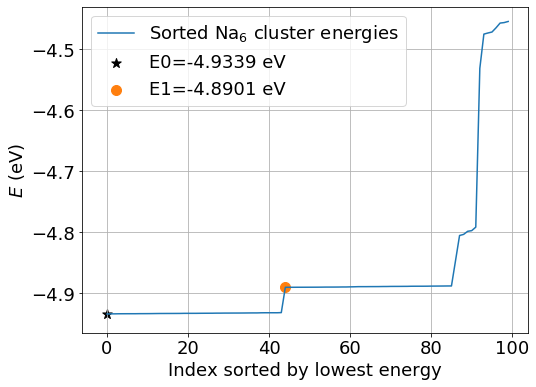

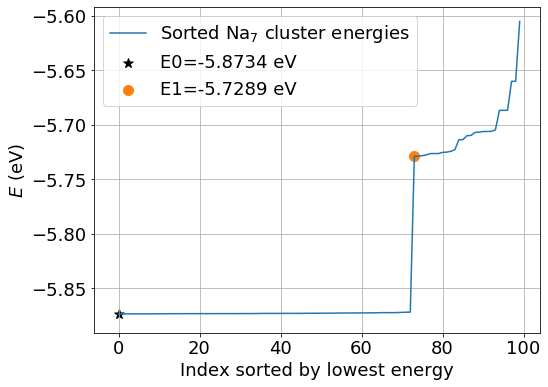

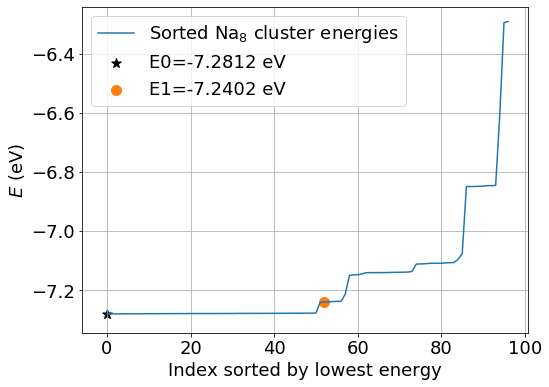

In [147]:
def second_most_stable(N):
    dirpath_t1 = f'./task1/Na{N}/'
    dirpath_t5 = f'./task5/'
    db = connect(f'{dirpath_t1}gadb.db')
    
    # Find all energies
    E = np.sort(np.array([row.energy for row in db.select(relaxed=True)]))
    # Find second most stable structure - defined by parameter tol
    tol = 0.04 # A difference of 0.04 eV as compared to lowest state is required
    E0 = E[0]
    idx_E1 = np.where(np.abs(E-E[0])>tol)[0][0]
    E1 = E[idx_E1]
    
    print(f'Na{N}: Energy difference between lowest and second lowest energy state: E1-E0={E1-E0:.4f} eV')
    
    # Plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(E, label=rf'Sorted $\rm Na_{N}$ cluster energies')
    ax.scatter(0, E0, marker='*', s=100, color='k', label=f'E0={E0:.4f} eV')
    ax.scatter(idx_E1, E1, marker='o', s=100, color='C1', label=f'E1={E1:.4f} eV')
    ax.legend()
    ax.set_xlabel("Index sorted by lowest energy")
    ax.set_ylabel(r"$E$ (eV)")
    ax.grid()
    

Ns = [6,7,8]
for N in Ns:
    second_most_stable(N)

Using a threshold difference of $\Delta E = 0.04\rm\, eV$ to differentiate between the first and second lowest energy stable configurations we obtain the following energy differences for the different number of Na atom clusters: 

* $\rm Na_6$: $\Delta E = 0.0438 \rm\, eV$
* $\rm Na_7$: $\Delta E = 0.1446 \rm\, eV$
* $\rm Na_8$: $\Delta E = 0.0410 \rm\, eV$

Thus we see that the difference in energy is at the $~0.1 \rm\, eV$ scale. **TODO Motivate!** 

# Task 8 - A closer look at Na6

Relax the structures for $\rm Na_6$ in the repository folder, using the same script as in problem 3. I will try the following basis sets, functionals and modify these parameters:  

* GPAW modes: Plane waves (PD), finite differences (FD) and LCAO for Na (dzp basis).
* Functionals: LSDA, PBE 
* Parameters: nbands=10, 15

This yields a total of 12 rows in the table. Note the use of paropen and parprint in GPAW. This is since I want to speed up the calculation by using multiple cores on hebbe.

In [255]:
# Built-in packages
import time

# Third-party packages
import numpy as np

from ase import Atoms
from ase.ga.utilities import closest_distances_generator
from ase.visualize import view
from ase.optimize import GPMin
from ase.parallel import paropen
from ase.parallel import parprint
from ase.io import read

# from gpaw import GPAW, FermiDirac, PW


np.random.seed(1)
d = 20  # cell size
db_file = 'expect.db'  # Filename for each of the databases

def test_params_Na6(m, f, nb):
    parprint(f'************ Na6 - Mode: {m} - Functional: {f} - nbands={nbands} ************')
    start = time.time()
    structpath=f'./Na-clusters-GA-search/Na6-structures/'  
    #**** Initialize system ****#
    clust0 = read(filename=f'{structpath}christmas-tree.xyz', format='xyz')
    clust1 = read(filename=f'{structpath}half-decahedron.xyz', format='xyz')
    #**** Define the calculator ****#
#     if m=='pw':
#         calc = GPAW(nbands=nb,
#                     h=0.25,
#                     txt=f'outfiles/Na6_{m}_{f}_{nb}_out.txt',
#                     occupations=FermiDirac(0.05),
#                     setups={'Na': '1'},
#                     mode=PW(350))
#     elif m=='fd':
#         calc = GPAW(nbands=nb,
#                     h=0.25,
#                     txt=f'outfiles/out.txt',
#                     occupations=FermiDirac(0.05),
#                     setups={'Na': '1'},
#                     mode='fd')
#     elif m=='lcao':
#         calc = GPAW(nbands=nb,
#                     h=0.25,
#                     txt=f'outfiles/out.txt',
#                     occupations=FermiDirac(0.05),
#                     setups={'Na': '1'},
#                     mode='lcao',
#                     basis='dzp')
#     #**** Relax the system ****#

#     clust0.set_calculator(calc)
#     dyn0 = GPMin(clust0, trajectory=f'trajectories/Na6_0_{m}_{f}_{nb}_relax_clust.traj', logfile=f'logiles/Na6_0_{m}_{f}_{nb}_relax_clust.log')
#     clust1.set_calculator(calc)
#     dyn1 = GPMin(clust1, trajectory=f'trajectories/Na6_1_{m}_{f}_{nb}_relax_clust.traj', logfile=f'logiles/Na6_1_{m}_{f}_{nb}_relax_clust.log')
    
#     parprint(f'****    Relaxing system of atoms    ****')
#     dyn0.run(fmax=0.02, steps=1)
#     dyn1.run(fmax=0.02, steps=1)

#     #**** Calculate energy and wavefunction ****#
#     e0 = clust0.get_potential_energy()  # Note opposite signa from ga.py
#     e1 = clust1.get_potential_energy()
    e0 = 1
    e1 = 1
    ef = paropen(f'Na6_e_table.txt', 'a')
    #**** Print to file *****#
    ef.write('-'*78 +'\n')
    ef.write(f'# Mode: {m}' + '|'.rjust(15-len(f'# Mode: {m}')) + '\n')
    subrow1 = f'# XC: {f}' + '|'.rjust(15-len(f'# XC: {f}'))
    subrow2 = f'{e0:.8f} eV \t\t {e1:.8f} eV'.rjust(50-len(subrow1))
    ef.write(subrow1+subrow2 + '\n')
    ef.write(f'# nbands = {nb}' + '|'.rjust(15-len(f'# nbands = {nb}')) + '\n')
    
    end = time.time()
    parprint(f'****    Elapsed time: {(end-start):.2f} s    ' + '****'.rjust(8))
    parprint('*'*77 + '\n')
    #*****************************#

# Parameters to perform grid search over
modes = ['pw', 'fd', 'lcao']
functionals=['LSDA', 'PBE']
nbands = [10, 15]

# Prepare file with headers
ef = paropen(f'Na6_e_table.txt', 'w')
subheader1 = ' Parameters ' + '|'.rjust(15-len(' Parameters '))
subheader2 = '\t\t\t E0 \t\t\t\t  E1'
ef.write(subheader1+subheader2+'\n')
ef.close()
# Iterate over all parameters
print('#'*25 + '\tStarting calculation\t' + '#'*25)
start = time.time()
for m in modes:
    for f in functionals:
        for nb in nbands:
            test_params_Na6(m, f, nb)
end = time.time()
print('#'*25 + (f'\tElapsed time: {(end-start):.2f} s\t' + '#'*25).rjust(20))
ef = paropen(f'Na6_e_table.txt', 'a')
ef.write('-'*78)
ef.close()

#########################	Starting calculation	#########################
************ Na6 - Mode: pw - Functional: LSDA - nbands=[10, 15] ************
****    Elapsed time: 0.00 s        ****
*****************************************************************************

************ Na6 - Mode: pw - Functional: LSDA - nbands=[10, 15] ************
****    Elapsed time: 0.00 s        ****
*****************************************************************************

************ Na6 - Mode: pw - Functional: PBE - nbands=[10, 15] ************
****    Elapsed time: 0.00 s        ****
*****************************************************************************

************ Na6 - Mode: pw - Functional: PBE - nbands=[10, 15] ************
****    Elapsed time: 0.00 s        ****
*****************************************************************************

************ Na6 - Mode: fd - Functional: LSDA - nbands=[10, 15] ************
****    Elapsed time: 0.00 s        ****
******************

# Task 9 - Which calculuation is the most accurate?

# Task 10 - Looking at the wave functions